https://docs.google.com/document/d/1-88e_XNNtWTNs8dCpjhM4-XGqfvU5GEu2YWHwo5hCR4/edit#heading=h.fgdpsk66a3kh

## Ensemble of Computational Linguists, NLP algorithms and Graph Theory

**Knowledge graphs** are tools of data science that deals with interconnected entities(people, organization, places, events etc). Entities are the nodes which are connnectes via edges. Knowledge graph consist of these entity pairs that can be traversed to uncover meaningful connections in unstructured data.

In [ ]:
%pip install wikipedia-api pandas spacy networkx scipy neptune-notebooks psutil

In [2]:
import spacy
spacy.cli.download("en_core_web_sm")
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [22]:
import spacy
import pandas as pd
# import en_core_web_sm

nlp = spacy.load('en_core_web_lg')

from spacy.tokens import Span
from spacy.matcher import Matcher

import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx

%matplotlib inline

In [23]:
data = pd.read_csv('scraped_data.csv')
data.head()

,Unnamed: 0,page,text,link,categories,topic
0,0,COVID 19,Coronavirus disease 2019 (COVID-19) is a conta...,https://en.wikipedia.org/wiki/COVID-19,"['All Wikipedia articles in need of updating',...",COVID 19
1,1,2020 Russia–Saudi Arabia oil price war,"On 8 March 2020, Saudi Arabia initiated a pric...",https://en.wikipedia.org/wiki/2020_Russia%E2%8...,"['2020 in Russia', '2020 in Saudi Arabia', '20...",COVID 19
2,2,2020 Tablighi Jamaat COVID-19 hotspot in Malaysia,A Tablighi Jamaat religious conference that to...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"['2020s in Malaysia', 'COVID-19 pandemic in Ma...",COVID 19
3,3,2020 UK GCSE and A-Level grading controversy,Due to the COVID-19 pandemic in the United Kin...,https://en.wikipedia.org/wiki/2020_UK_GCSE_and...,"['2020 controversies', '2020 in the United Kin...",COVID 19
4,4,2020 stock market crash,The 2020 stock market crash was a major and su...,https://en.wikipedia.org/wiki/2020_stock_marke...,"['2020 in economics', 'All articles with dead ...",COVID 19


In [24]:
data['text'][10]

'The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by the UK Rapid Test Consortium and manufactured by Abingdon Health. It uses a lateral flow test to determine whether a person has IgG antibodies to the SARS-CoV-2 virus that causes COVID-19. The test uses a single drop of blood obtained from a finger prick and yields results in 20 minutes.\n\nSee also\nCOVID-19 rapid antigen test\n\nReferences\nExternal links\nOfficial website\nAbC 19 Rapid Test Instructions'

## Segmenting Sentences

In [25]:
# Lets take part of the above extracted article
docu = nlp('''The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by 
the UK Rapid Test Consortium and manufactured by Abingdon Health. It uses a lateral flow test to determine 
whether a person has IgG antibodies to the SARS-CoV-2 virus that causes COVID-19. The test uses a single 
drop of blood obtained from a finger prick and yields results in 20 minutes.\n\nSee also\nCOVID-19 rapid 
antigen test''')

for tokn in docu:
    print(tokn.text, "---", tokn.dep_)

The --- det
AbC-19 --- amod
rapid --- amod
antibody --- compound
test --- nsubj
is --- ROOT
an --- det
immunological --- amod
test --- attr
for --- prep
COVID-19 --- amod
exposure --- pobj
developed --- acl
by --- agent

 --- 
the --- det
UK --- compound
Rapid --- compound
Test --- compound
Consortium --- pobj
and --- cc
manufactured --- conj
by --- agent
Abingdon --- compound
Health --- pobj
. --- punct
It --- nsubj
uses --- ROOT
a --- det
lateral --- amod
flow --- compound
test --- dobj
to --- aux
determine --- xcomp

 --- 
whether --- mark
a --- det
person --- nsubj
has --- ccomp
IgG --- compound
antibodies --- dobj
to --- prep
the --- det
SARS --- compound
- --- punct
CoV-2 --- compound
virus --- pobj
that --- nsubj
causes --- relcl
COVID-19 --- dobj
. --- punct
The --- det
test --- nsubj
uses --- ROOT
a --- det
single --- amod

 --- 
drop --- dobj
of --- prep
blood --- pobj
obtained --- acl
from --- prep
a --- det
finger --- compound
prick --- pobj
and --- cc
yields --- conj
resul

## Extracting entities

In [27]:
def extract_entities(sents):
    # chunk one
    enti_one = ""
    enti_two = ""
    
    dep_prev_token = "" # dependency tag of previous token in sentence
    
    txt_prev_token = "" # previous token in sentence
    
    prefix = ""
    modifier = ""
    
    
    
    for tokn in nlp(sents):
        # chunk two
        ## move to next token if token is punctuation
        
        if tokn.dep_ != "punct":
            #  check if token is compound word or not
            if tokn.dep_ == "compound":
                prefix = tokn.text
                # add current word to it if prevoius word is 'compound
                if dep_prev_token == "compound":
                    prefix = txt_prev_token + " "+ tokn.text
                    
            # verify if token is modifier or not
            if tokn.dep_.endswith("mod") == True:
                modifier = tokn.text
                # add it to the current word if previous word is 'compound'
                if dep_prev_token == "compound":
                    modifier = txt_prev_token + " "+ tokn.text
                    
            # chunk3
            if tokn.dep_.find("subj") == True:
                enti_one = modifier +" "+ prefix + " "+ tokn.text
                prefix = ""
                modifier = ""
                dep_prev_token = ""
                txt_prev_token = ""
                
            # chunk4 
            if tokn.dep_.find("obj") == True:
                enti_two = modifier +" "+ prefix +" "+ tokn.text
                
            # chunk 5
            # update variable
            dep_prev_token = tokn.dep_
            txt_prev_token = tokn.text
            
    return [enti_one.strip(), enti_two.strip()]

In [28]:
extract_entities("The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by the UK Rapid Test")

['rapid antibody test', 'COVID-19 UK Rapid Test']

In [30]:
pairs_of_entities = []

for i in tqdm(data['text'][:800]):
    pairs_of_entities.append(extract_entities(i))

100%|██████████| 800/800 [04:28<00:00,  2.98it/s]


In [33]:
pairs_of_entities[36:42]

[['where aluminium powder', 'such explosives manufacturing'],
 ['310  people', 'Anal Cancer Research UK'],
 ['converting UCSC Genome enzyme', '2 PDBe KB'],
 ['which', '1 US National Medicine'],
 ['converting UCSC Genome enzyme', '2 PDBe KB'],
 ['users', 'permanently  taste']]

## Relation extraction

In [34]:
def obtain_relation(sent):
    
    doc = nlp(sent)
    
    matcher = Matcher(nlp.vocab)
    
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]
    
    matcher.add("matching_1", None, pattern)
    
    matcher = matcher(doc)
    h = len(matcher) - 1
    
    span = doc[matcher[h][1]:matcher[h][2]]
    
    return (span.text)

In [ ]:
# obtain_relation("The AbC-19 rapid antibody test is an immunological test for COVID-19 exposure developed by the UK Rapid Test")

In [35]:
relations = [obtain_relation(j) for j in tqdm(data['text'][:800])]

 40%|███▉      | 316/800 [01:36<04:51,  1.66it/s]

In [17]:
pd.Series(relations).value_counts()[:50]

References       51
Factors          37
links            23
website           5
Media             3
Headings          3
protects          2
Antibody from     2
May               2
enzyme            2
text of           2
summary           2
Library of        2
PMID              2
Notes             2
Be                1
factsheet on      1
Dictionary        1
History of        1
ISBN              1
ages              1
Times             1
feel              1
Vaccine for       1
homepage          1
Coronaviridae     1
protein           1
biography         1
Carpet in         1
NIOSH             1
Resistance of     1
reading           1
Aylwar at         1
Types Of          1
S2CID             1
Intercept         1
Coronavirus       1
Agency            1
ISSN              1
Isolation         1
Foundation        1
See               1
Asked             1
toolkit           1
Biosafety in      1
AIDS at           1
published         1
Inhibitors        1
Instructions      1
website of        1


## Building graph

In [18]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [19]:
# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target", edge_attr=True, create_using=ntx.MultiDiGraph())

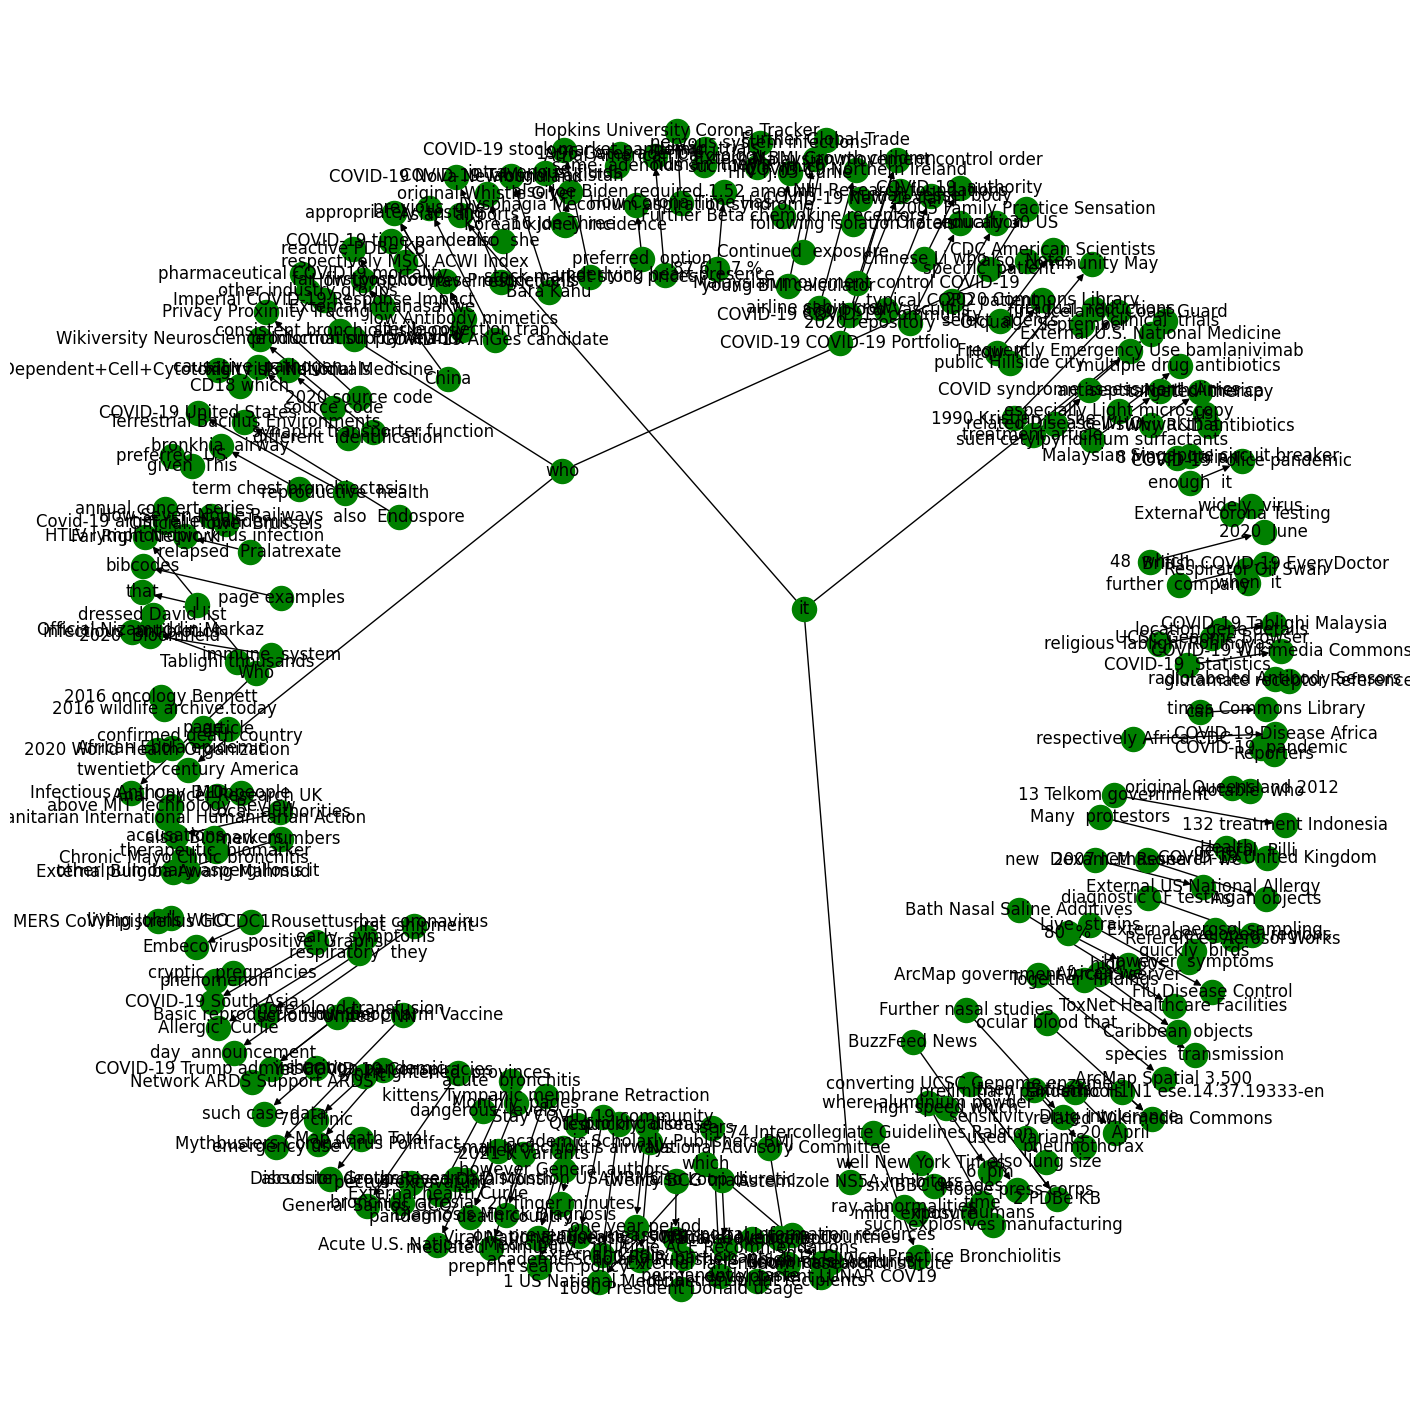

In [20]:
plot.figure(figsize=(14, 14))

posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

### Refine your graph based on certain relations

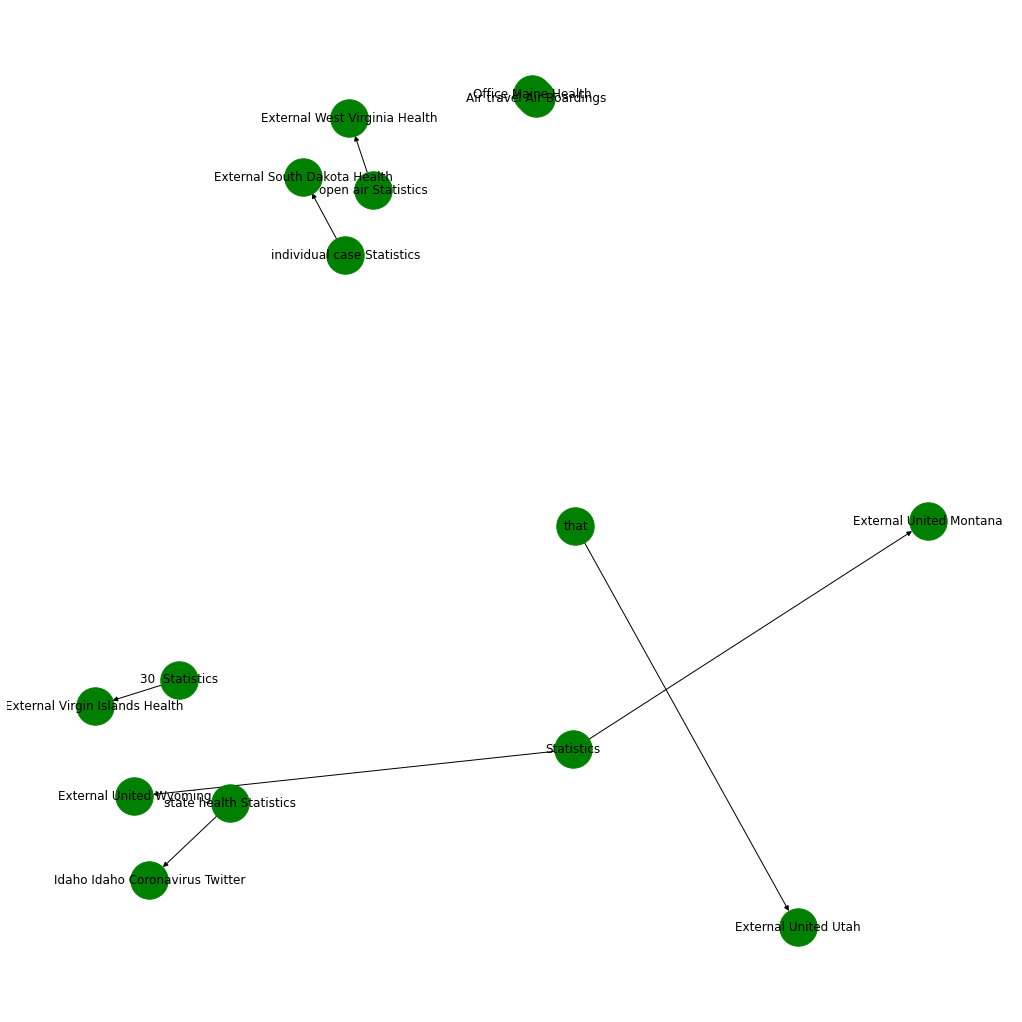

In [24]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="Information from"], "source", "target", edge_attr=True, create_using=ntx.MultiDiGraph())

plot.figure(figsize=(14,14))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

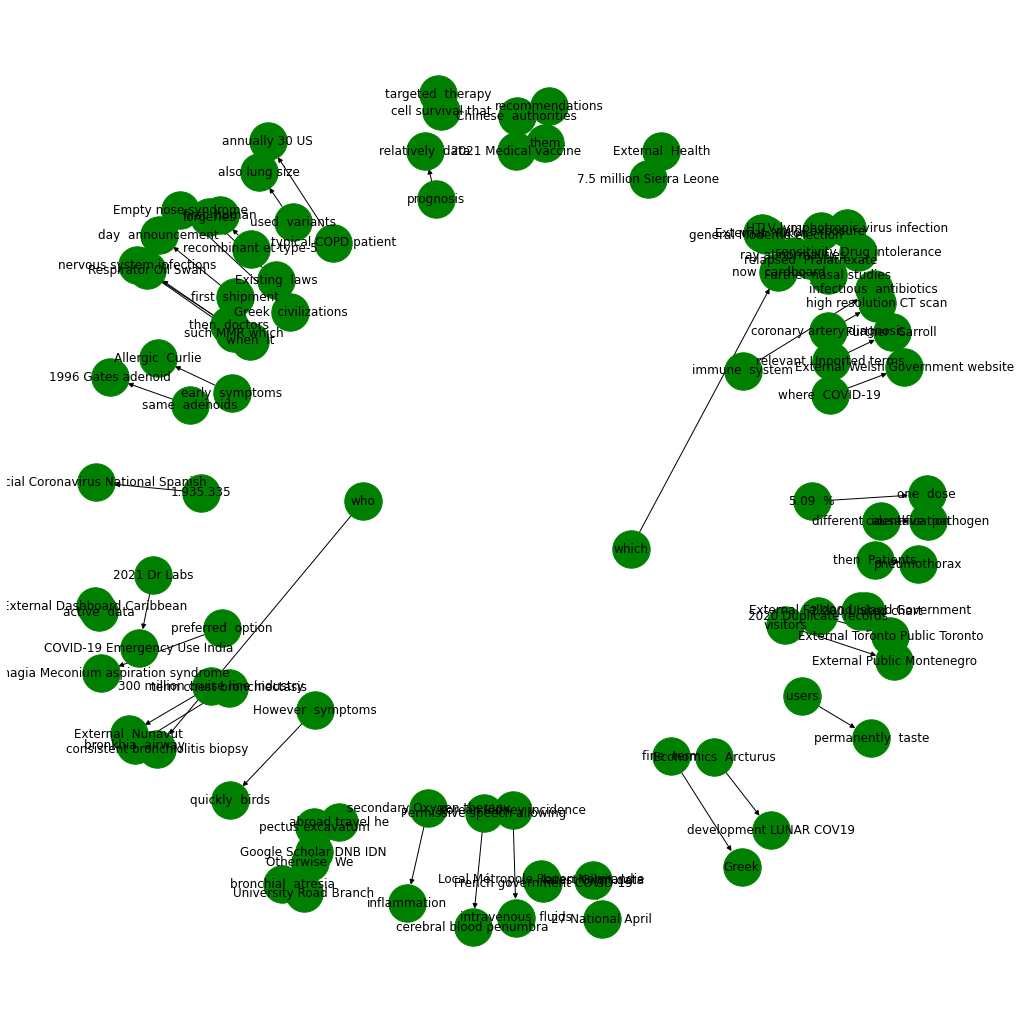

In [25]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="links"], "source", "target", 
                          edge_attr=True, create_using=ntx.MultiDiGraph())

plot.figure(figsize=(14,14))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()